## Preprocess pan-cancer methylation data (27k probes)

Load the downloaded data and curate sample IDs.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.tcga_utilities as tu

### Read TCGA Barcode Curation Information

Extract information from TCGA barcodes - `cancer-type` and `sample-type`. See https://github.com/cognoma/cancer-data for more details

In [2]:
(cancer_types_df,
 cancertype_codes_dict,
 sample_types_df,
 sampletype_codes_dict) = tu.get_tcga_barcode_info()
cancer_types_df.head(2)

,TSS Code,Source Site,Study Name,BCR,acronym
0,01,International Genomics Consortium,ovarian serous cystadenocarcinoma,IGC,OV
1,02,MD Anderson Cancer Center,glioblastoma multiforme,IGC,GBM


In [3]:
sample_types_df.head(2)

,Code,Definition,Short Letter Code
0,01,Primary Solid Tumor,TP
1,02,Recurrent Solid Tumor,TR


### Load and process methylation data

In [4]:
# first load manifest file, this tells us the filenames of the raw data files
manifest_df = pd.read_csv(os.path.join(cfg.data_dir, 'manifest.tsv'),
                          sep='\t', index_col=0)
manifest_df.head(2)

,id,filename,md5,size
name,,,,
mirna_sample,55d9bf6f-0712-4315-b588-e6f8e295018e,PanCanAtlas_miRNA_sample_information_list.txt,02bb56712be34bcd58c50d90387aebde,553408
methylation_27k,d82e2c44-89eb-43d9-b6d3-712732bf6a53,jhu-usc.edu_PANCAN_merged_HumanMethylation27_H...,5cec086f0b002d17befef76a3241e73b,5022150019


In [5]:
tcga_methylation_df = (
    pd.read_csv(os.path.join(cfg.raw_data_dir, manifest_df.loc['methylation_27k'].filename),
                index_col=0, sep='\t')
      .transpose()
)
tcga_methylation_df.index.rename('sample_id', inplace=True)

print(tcga_methylation_df.shape)
tcga_methylation_df.iloc[:5, :5]

(12039, 22601)


Composite Element REF,cg00000292,cg00003994,cg00005847,cg00007981,cg00008493
sample_id,,,,,
TCGA-02-0001-01C-01D-0186-05,0.846378,0.066406,0.330927,0.026121,0.925941
TCGA-02-0003-01A-01D-0186-05,0.732044,0.131451,0.839389,0.039102,0.934192
TCGA-02-0006-01B-01D-0186-05,0.678917,0.089675,0.469196,0.021105,0.924509
TCGA-02-0007-01A-01D-0186-05,0.846951,0.040882,0.355053,0.039487,0.930292
TCGA-02-0009-01A-01D-0186-05,0.855192,0.066100,0.605179,0.025252,0.926921


In [6]:
# how many missing values does each probe (column) have?

# TODO could move analyses to a separate script (so preprocessing is more 
# straightforward/less cluttered)
probe_na = tcga_methylation_df.isna().sum()
print(probe_na.shape)
probe_na.sort_values(ascending=False).head()

(22601,)


Composite Element REF
cg20401549    4185
cg17901463    2941
cg02549424    2918
cg08797194    2372
cg27400772    2211
dtype: int64

In [7]:
# how many missing values does each probe (column) have?
sample_na = tcga_methylation_df.transpose().isna().sum()
print(sample_na.shape)
sample_na.sort_values(ascending=False).head()

(12039,)


sample_id
TCGA-C8-A134-01A-11D-A112-05    1906
TCGA-37-3789-01A-01D-0979-05    1393
TCGA-23-1027-01A-02D-0432-05    1361
TCGA-CJ-4887-11A-01D-1303-05    1353
TCGA-17-Z012-01A-01D-0752-05    1304
dtype: int64

Text(0.5, 1.0, 'Methylation NA count per probe, <20 NA values')

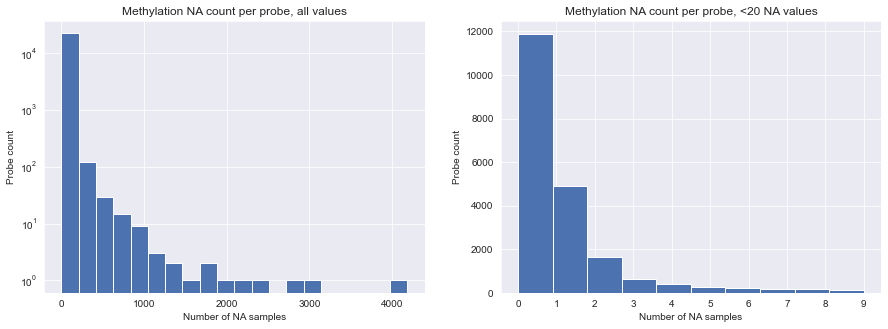

In [8]:
# how many probes (columns) have missing values?

sns.set({'figure.figsize': (15, 5)})
fig, axarr = plt.subplots(1, 2)

# plot distribution of all NA sample probes, with log scale y axis
probe_na.plot.hist(bins=20, ax=axarr[0])
axarr[0].set_yscale('log')
axarr[0].set_xlabel('Number of NA samples')
axarr[0].set_ylabel('Probe count')
axarr[0].set_title('Methylation NA count per probe, all values')

# hard to see distribution of few NA sample probes, so filter and plot
# without log scale
#
# this plot answers the question: how many additional features/predictors
# would we gain by imputing values for probes with only very few NAs?
probe_na_low = probe_na[probe_na.values < 10]
probe_na_low.plot.hist(bins=len(probe_na_low.unique()), ax=axarr[1])
axarr[1].set_xlabel('Number of NA samples')
axarr[1].set_xticks(range(10))
axarr[1].set_ylabel('Probe count')
axarr[1].set_title('Methylation NA count per probe, <20 NA values')

Text(0.5, 1.0, 'Methylation NA count per sample, >500 NA values')

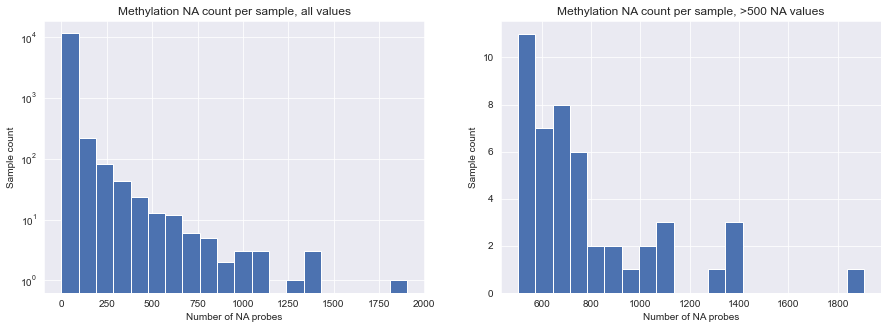

In [9]:
# as an alternate approach to imputation, we could filter out "bad" samples,
# or samples with many NA probes
#
# we'll start by asking: how many samples (rows) have missing values?

sns.set({'figure.figsize': (15, 5)})
fig, axarr = plt.subplots(1, 2)

# plot distribution of all NA probe samples, with log scale y axis
sample_na.plot.hist(bins=20, ax=axarr[0])
axarr[0].set_yscale('log')
axarr[0].set_xlabel('Number of NA probes')
axarr[0].set_ylabel('Sample count')
axarr[0].set_title('Methylation NA count per sample, all values')

# let's look in more detail at the "bad" samples, defined as samples with NA
# counts over some min threshold
sample_na_high = sample_na[sample_na.values > 500]
sample_na_high.plot.hist(bins=20, ax=axarr[1])
axarr[1].set_xlabel('Number of NA probes')
axarr[1].set_ylabel('Sample count')
axarr[1].set_title('Methylation NA count per sample, >500 NA values')

In [10]:
# now, the question we want to answer is: if we remove "bad" samples,
# how many more valid probes do we get?
#
# to explore this, we'll remove samples in descending order of their
# NA count, and see how many additional probes (predictors) this filtering
# gives us
def filter_bad_samples(methylation_df, bad_samples):
    return (
        methylation_df.copy()
                      .loc[~methylation_df.index.isin(bad_samples)]
                      .dropna(axis='columns')
    )

def count_probes_for_range(sample_counts):
    probe_sample_count = []
    sample_sorted = sample_na.sort_values(ascending=False)
    for filter_count in sample_counts:
        bad_samples = sample_sorted.iloc[:filter_count].index.values
        filtered_df = filter_bad_samples(tcga_methylation_df, bad_samples)
        probe_sample_count.append((filter_count, len(filtered_df.columns)))
    return list(zip(*probe_sample_count))

probe_counts_small = count_probes_for_range(range(20))
probe_counts_large = count_probes_for_range(range(0, 510, 10))

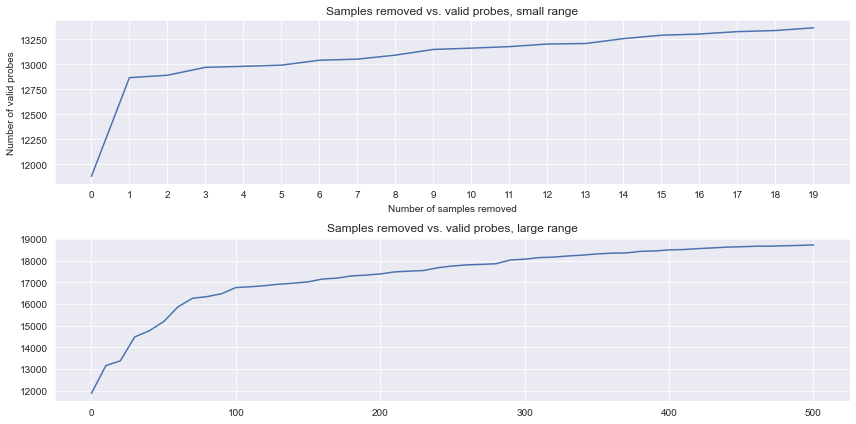

In [11]:
sns.set({'figure.figsize': (12, 6)})
fig, axarr = plt.subplots(2, 1)
sns.lineplot(x=probe_counts_small[0], y=probe_counts_small[1], ax=axarr[0])
axarr[0].set_xticks(probe_counts_small[0])
axarr[0].set_xlabel('Number of samples removed')
axarr[0].set_ylabel('Number of valid probes')
axarr[0].set_title('Samples removed vs. valid probes, small range')
sns.lineplot(x=probe_counts_large[0], y=probe_counts_large[1], ax=axarr[1])
axarr[0].set_xlabel('Number of samples removed')
axarr[0].set_ylabel('Number of valid probes')
axarr[1].set_title('Samples removed vs. valid probes, large range')
plt.tight_layout()

In [12]:
# remove 10 samples, then impute for probes with 1 or 2 NA values
n_filter = 10
n_impute = 5

samples_sorted = sample_na.sort_values(ascending=False)
output_dir = os.path.join(cfg.data_dir, 'methylation_preprocessed')
os.makedirs(output_dir, exist_ok=True)

def filter_na_samples(methylation_df, bad_samples):
    # don't drop NA columns, we'll do that after imputation
    return (
        methylation_df.copy()
                      .loc[~methylation_df.index.isin(bad_samples)]
    )

def impute_leq(methylation_df, n_na):
    if n_na == 0:
        return methylation_df
    else:
        return methylation_df.fillna(methylation_df.mean(), limit=n_na)

# filter, impute, drop NA columns
print(tcga_methylation_df.shape)
samples_for_count = samples_sorted.iloc[:n_filter].index.values
tcga_methylation_df = filter_na_samples(tcga_methylation_df,
                                        samples_for_count)
print(tcga_methylation_df.shape)
tcga_methylation_df = (
    impute_leq(tcga_methylation_df, n_impute).dropna(axis='columns')
)
print(tcga_methylation_df.shape)

# update sample IDs to remove multiple samples measured on the same tumor
# and to map with the clinical information
tcga_methylation_df.index = tcga_methylation_df.index.str.slice(start=0, stop=15)
tcga_methylation_df = tcga_methylation_df.loc[~tcga_methylation_df.index.duplicated(), :]

print(tcga_methylation_df.shape)
filtered_file = os.path.join(output_dir,
                             'methylation_processed_n{}_i{}.tsv.gz'.format(n_filter, n_impute))
print(filtered_file)

(12039, 22601)
(12029, 22601)
(12029, 20040)
(11975, 20040)
/home/jake/research/mpmp/data/methylation_preprocessed/methylation_processed_n10_i5.tsv.gz


In [13]:
tcga_methylation_df.to_csv(filtered_file, sep='\t', float_format='%.3g')

### Process TCGA cancer type and sample type info from barcodes

See https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/tissue-source-site-codes for more details.

In [14]:
# get sample info and save to file

tcga_id = tu.get_and_save_sample_info(tcga_methylation_df,
                                      sampletype_codes_dict,
                                      cancertype_codes_dict,
                                      training_data='me_27k')

print(tcga_id.shape)
tcga_id.head()

(11975, 4)


,sample_id,sample_type,cancer_type,id_for_stratification
0,TCGA-02-0001-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
1,TCGA-02-0003-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
2,TCGA-02-0006-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
3,TCGA-02-0007-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
4,TCGA-02-0009-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor


In [15]:
# get cancer type counts and save to file
cancertype_count_df = (
    pd.DataFrame(tcga_id.cancer_type.value_counts())
    .reset_index()
    .rename({'index': 'cancertype', 'cancer_type': 'n ='}, axis='columns')
)

file = os.path.join(cfg.sample_info_dir, 'tcga_me_27k_sample_counts.tsv')
cancertype_count_df.to_csv(file, sep='\t', index=False)

cancertype_count_df.head()

,cancertype,n =
0,BRCA,1188
1,KIRC,860
2,LUAD,624
3,OV,615
4,UCEC,578


### Dimension reduction

Compress the data using PCA with various dimensions, and save the results to tsv files.

In [16]:
from sklearn.decomposition import PCA

pca_dir = os.path.join(cfg.data_dir, 'me_compressed')
os.makedirs(pca_dir, exist_ok=True)

n_pcs_list = [100, 1000, 5000]
var_exp_list = []
for n_pcs in n_pcs_list:
    pca = PCA(n_components=n_pcs, random_state=cfg.default_seed)
    me_pca = pca.fit_transform(tcga_methylation_df)
    print(me_pca.shape)
    var_exp_list.append(pca.explained_variance_ratio_)
    me_pca = pd.DataFrame(me_pca, index=tcga_methylation_df.index)
    me_pca.to_csv(os.path.join(pca_dir,
                               'me_27k_f{}_i{}_pc{}.tsv.gz'.format(
                                   n_filter, n_impute, n_pcs)),
                  sep='\t',
                  float_format='%.3g')

(11975, 100)
(11975, 1000)
(11975, 5000)


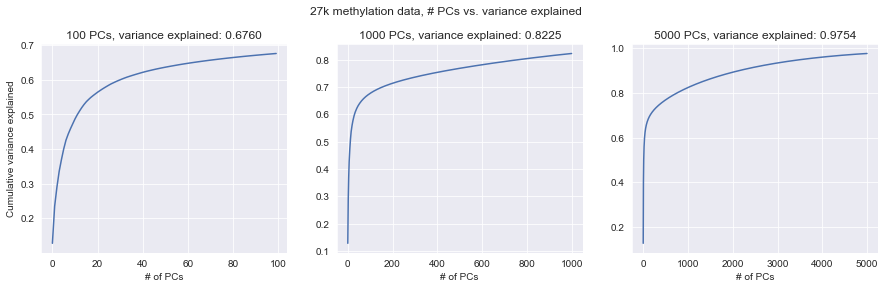

In [17]:
# plot PCA variance explained
sns.set({'figure.figsize': (15, 4)})
fig, axarr = plt.subplots(1, 3)

for ix, ve in enumerate(var_exp_list):
    sns.lineplot(x=range(len(ve)), y=np.cumsum(ve), ax=axarr[ix])
    axarr[ix].set_title('{} PCs, variance explained: {:.4f}'.format(
        n_pcs_list[ix], sum(ve, 0)))
    axarr[ix].set_xlabel('# of PCs')
    if ix == 0:
        axarr[ix].set_ylabel('Cumulative variance explained')
plt.suptitle('27k methylation data, # PCs vs. variance explained')
plt.subplots_adjust(top=0.85)